<a href="https://colab.research.google.com/github/luyuzhe111/image-caption-match/blob/main/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import os

In [3]:
os.chdir('/content/drive/MyDrive/kaggle/wikipedia')

In [4]:
import pandas as pd
from tqdm import tqdm

# Import packages

In [5]:
! pip install -q albumentations==0.4.6

In [6]:
! pip install cairosvg

In [7]:
! pip install transformers

In [8]:
import glob
import gc
gc.enable()
import multiprocessing
import cv2
import copy
import time
import random
from PIL import Image
from PIL import ImageFile

import base64
import pickle

# fold
from sklearn.model_selection import StratifiedKFold

# For downloading images
from io import BytesIO

# For data manipulation
import numpy as np
import pandas as pd
from numpy import asarray

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.cuda import amp
import torchvision


# Utils
import joblib
from tqdm import tqdm
from collections import defaultdict

# Sklearn Imports
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import StratifiedKFold, KFold

# For Image Models
# import timm

# For Transformer Models
from transformers import AutoTokenizer, AutoModel
from transformers import BertTokenizer, BertModel, BertConfig

import torchvision.transforms as transforms

import warnings
warnings.filterwarnings("ignore")


# Load data

In [64]:
# load data from input files
df_train = pd.read_feather('./train-subsample.feather')
df_valid = pd.read_feather('./valid-subsample.feather')
df_test = pd.read_feather('./valid-subsample.feather')

In [65]:
df_train.head(3)

,language,image_url,caption_title_and_reference_description,page_title,path
0,fr,https://upload.wikimedia.org/wikipedia/commons...,Sacramentaire de Tyniec [SEP] Page du Vere dig...,Sacramentaire de Tyniec,./images/images0/fr/12214.jpg
1,fr,https://upload.wikimedia.org/wikipedia/commons...,Voïvodie des Basses-Carpates [SEP],Voïvodie des Basses-Carpates,./images/images2/fr/52498.jpg
2,sk,http://upload.wikimedia.org/wikipedia/commons/...,Edubuntu [SEP] Edubuntu 7.04 - Gaim a napaľovanie,Edubuntu,./images/images0/sk/13737.jpg


In [67]:
print(f'size of the train/val/test dataset: {len(df_train)}, {len(df_valid)}, {len(df_test)}')

size of the train/val/test dataset: 79346, 9918, 9918


# Set up


## config

In [12]:
def optimal_num_of_loader_workers():
    num_cpus = multiprocessing.cpu_count()
    num_gpus = torch.cuda.device_count()
    optimal_value = min(num_cpus, num_gpus*4) if num_gpus else num_cpus - 1
    return optimal_value

In [60]:
CONFIG = {
    "seed": 2021,
    "epochs": 5,#20,
    'nfolds':5,
    
    "img_size": 224,
    "text_model_name": "xlm-roberta-base",
    
    "embedding_size": 256,
    "train_batch_size": 64,
    "valid_batch_size": 64,
    "learning_rate": 1e-5,
    "scheduler": 'CosineAnnealingLR',
    "min_lr": 1e-6,
    'num_workers':4,
    
    "T_max": 500,
    "weight_decay": 1e-6,
    "max_length": 32,
    
    "n_accumulate": 1,
}

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['text_model_name'])

In [14]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

## transform set up

In [15]:
data_transforms = {
    "train": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ]),
    
    "valid": transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225)),
    ])
}

## helper to load image

In [16]:
def load_img(dir):
  image = Image.open(dir)
  return asarray(image)

# Dataset

In [17]:
class WikipediaDataset(Dataset):
    def __init__(self, data, tokenizer, max_length, transforms=None):
        self.data = data.reset_index(drop=True)
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.transforms = transforms
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        img = load_img(self.data.at[index, "path"])
        if self.transforms:
          img = self.transforms(img)
        
        caption = self.data.at[index, "caption_title_and_reference_description"]
        caption = caption.replace("[SEP]", "</s>") # sep token for xlm-roberta
        inputs = self.tokenizer.encode_plus(
            caption,
            truncation=True,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length'
        )
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
       
        return {
            'ids': torch.tensor(ids, dtype=torch.long),
            'mask': torch.tensor(mask, dtype=torch.long),
            'image': img
        }

# Dataloader

In [68]:
train_dataset = WikipediaDataset(df_train, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["train"])
train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], num_workers=CONFIG['num_workers'], shuffle=True, pin_memory=True)

valid_dataset = WikipediaDataset(df_valid, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["train"])
valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=CONFIG['num_workers'], shuffle=False, pin_memory=True)

test_dataset = WikipediaDataset(df_test, CONFIG["tokenizer"], CONFIG["max_length"], transforms=data_transforms["train"])
test_loader = DataLoader(test_dataset, batch_size=CONFIG['valid_batch_size'], num_workers=CONFIG['num_workers'], shuffle=False, pin_memory=True)

# Image model

In [19]:
from torchvision.models import resnet50

In [36]:
class ImageFeatureExtractor(nn.Module):
    def __init__(self, projector=[2048, 512, 64, 8], pool='gem-1'):
        super(ImageFeatureExtractor, self).__init__()
        model = resnet50(pretrained=True)
        modules = nn.ModuleList(model.children())[:-2]
        self.features = nn.Sequential(*modules)

        arch=[]
        for i in range(1,len(projector)):
            arch.append(nn.Linear(projector[i-1], projector[i]))
            if i!=len(projector)-1:
                arch.append(nn.ReLU())
        
        self.projector=nn.Sequential(*arch)
        self.pool = pool

    def forward(self, inputs):
        output = self.features(inputs)
        output = torch.flatten(output, start_dim=-2)
        if self.pool == 'gem-1':
          output = output.mean(-1)
        elif self.pool == 'gem-2':
          output = torch.pow((output ** 2).mean(-1), 1/2)
        output = self.projector(output)
        return output

In [61]:
projector = [2048, 512, 128, 32]
image_model = ImageFeatureExtractor(projector=projector).cuda()
for name, p in image_model.named_parameters():
  if 'features' in name:
    p.requires_grad = False

# Text model

In [62]:
class TextExtractorModel(nn.Module):
    def __init__(self, text_model, projector=[748, 96, 32]):
        super(TextExtractorModel, self).__init__()
        self.text_model = AutoModel.from_pretrained(text_model)

        arch=[]
        for i in range(1,len(projector)):
            arch.append(nn.Linear(projector[i-1], projector[i]))
            if i!=len(projector)-1:
                arch.append(nn.ReLU())
        
        self.projector=nn.Sequential(*arch)
        self.init_weights(self.projector)
        
    def init_weights(self, m):
        if type(m) == torch.nn.Linear:
            torch.nn.init.xavier_uniform_(m.weight)
            m.bias.data.fill_(0)
            
    def forward(self, ids, mask):
        out = self.text_model(input_ids=ids, attention_mask=mask, output_hidden_states=False)[1]
        text_embeddings = self.projector(out)
        return text_embeddings

In [63]:
projector=[748, 96, 32]
text_model = TextExtractorModel(CONFIG['text_model_name'], projector=projector).cuda()
for name, p in text_model.named_parameters():
  if 'text_model' in name:
    p.requires_grad = False

Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaModel: ['lm_head.decoder.weight', 'lm_head.layer_norm.bias', 'lm_head.bias', 'lm_head.layer_norm.weight', 'lm_head.dense.weight', 'lm_head.dense.bias']
- This IS expected if you are initializing XLMRobertaModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


# Optimizer

In [51]:
optimizer = optim.Adam([
                {'params': image_model.parameters()},
                {'params': text_model.parameters()}
            ], lr=CONFIG['learning_rate'], weight_decay=CONFIG['weight_decay'], betas=(0.9, 0.999), amsgrad=True)

# Loss function

In [52]:
class Loss(nn.Module):
    def __init__(self, eps=1e-6):
        super().__init__()
        self.cosine = nn.CosineEmbeddingLoss()
        
    def forward(self, inputs, targets):
        c_loss = self.cosine(inputs, targets, torch.ones(inputs.size(0)).cuda())
        return c_loss

In [53]:
criterion = Loss()

In [69]:
losses = []
for index, item in enumerate(tqdm(train_loader)):
  break
  optimizer.zero_grad()
  img = item['image'].cuda()
  mask = item['mask'].cuda()
  ids = item['ids'].cuda()          
  
  image_outputs = image_model(img)
  text_outputs = text_model(ids, mask)

  loss = criterion(image_outputs, text_outputs)
  loss.backward()
  optimizer.step()

  losses.append(loss)

  0%|          | 0/1240 [01:27<?, ?it/s]


In [58]:
import matplotlib.pyplot as plt

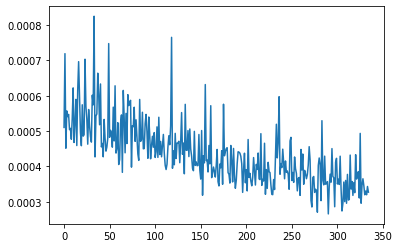

In [59]:
plt.plot(range(len(losses)), losses)
plt.show()